In [1]:
#

In [2]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:,.3f}'.format

%matplotlib inline

In [3]:
def _energy_loss(self, y_true, y_pred):
    event_filter = y_true[:,0] # ∈ n
    e_enrg_true = K.reshape(y_true[:,1],(-1,1)) # ∈ nx1
    e_enrg_pred = K.reshape(y_pred[:,0],(-1,1)) # ∈ nx1
    p_enrg_true = K.reshape(y_true[:,2],(-1,1)) # ∈ nx1
    p_enrg_pred = K.reshape(y_pred[:,1],(-1,1)) # ∈ nx1

    e_loss = keras.losses.mse(e_enrg_true, e_enrg_pred) # ∈ n
    e_loss = event_filter * e_loss

    p_loss = keras.losses.mse(p_enrg_true, p_enrg_pred) # ∈ n
    p_loss = event_filter * p_loss

    return e_loss + p_loss

AI._energy_loss = _energy_loss

In [4]:
model_name = 'model-2a-msf'
shuffle_clusters = False

data = DataModel('data-mtx-enough-top-6.npz', 
                 batch_size = 64, validation_percent = .05, test_percent = .1)
data.append_dim = True

ai = AI(data, model_name)

np.random.seed(888)
ai.data.shuffle(only_train=False)

if shuffle_clusters:
    ai.data.shuffle_training_clusters()

ai.data.weight_non_compton = .5
ai.weight_type = .05
ai.weight_e_cluster = .8
ai.weight_p_cluster = .8
ai.weight_pos_x = 12
ai.weight_pos_y = 2
ai.weight_pos_z = 8
ai.weight_energy = 1

f = 2
ai.energy_factor_limit = .06 * f
ai.position_absolute_limit = np.array([1.3,5,1.3]) * f

In [5]:
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64], energy_layers=[32], base_l2=.000, limbs_l2=.000)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 54, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 6, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 6, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 384)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [6]:
ai.compile_model(learning_rate=0.0003)

In [7]:
%%time
ai.train(epochs=100, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0)
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

17443/17443 [==============================] - 33s 2ms/step - loss: 0.3266 - e_cluster_loss: 0.0281 - p_cluster_loss: 0.0739 - type_loss: 0.2995 - pos_x_loss: 6.3961e-04 - pos_y_loss: 0.0377 - pos_z_loss: 6.3882e-04 - energy_loss: 0.1418 - e_cluster__cluster_accuracy: 0.9604 - p_cluster__cluster_accuracy: 0.8958 - type__type_accuracy: 0.8722 - type__type_tp_rate: 0.8737

CPU times: user 1d 13h 46min 23s, sys: 10min 19s, total: 1d 13h 56min 42s
Wall time: 1d 14h 3min 50s


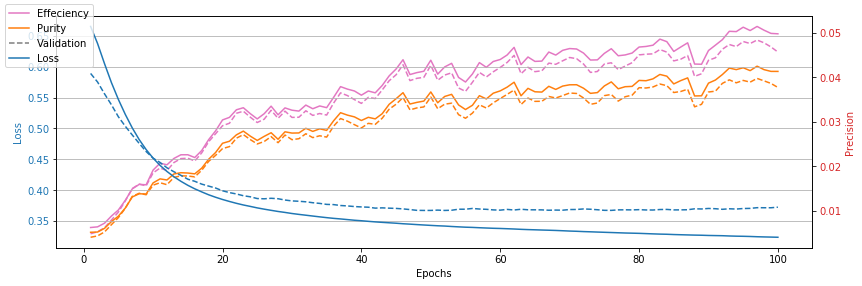

AI model
  Loss:        0.37502
    -Type:         0.30485 *  0.05 = 0.01524
    -Pos X:        0.00072 * 12.00 = 0.00866
    -Pos Y:        0.03851 *  2.00 = 0.07701
    -Pos Z:        0.00073 *  8.00 = 0.00581
    -Energy:       0.17218 *  1.00 = 0.17218
    -Cls e:        0.03630 *  0.80 = 0.02904
    -Cls p:        0.08383 *  0.80 = 0.06707
  Accuracy:    0.87106
    -TP rate:      0.87241
    -Cls e rate:   0.95152
    -Cls p rate:   0.88720
  Efficiency:  0.04885
  Purity:      0.04103
  Euc mean:   11.55858
  Euc std:    29.70090

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [8]:
ai.plot_training_loss(smooth=True)
ai.evaluate()

In [9]:
ai.save(file_name=model_name)